In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold,SelectKBest, chi2, SelectFromModel
from sklearn.svm import SVC
from sklearn.metrics import f1_score,classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import xgboost


## Objectif :

- Understand data as much as possible

- Develop a forst strategy of modeling


## Checklist :

### Analysis of the form

- **Identify target variable**
- **Shape of data**
- **Type of variables**
- **Missing values**

### Analysis of the substance 

- **Target Visualization**
- **Signficance of the variables**
- **Relationship between target and variables**

In [3]:
# Load data

df_ = pd.read_excel('Covid_19.xlsx')
df = pd.DataFrame(df_) 
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)



In [3]:
pd.reset_option('^display.', silent=True)

## Columns type

In [4]:
# Summary of info
df.info(verbose = True) # to display the whole info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 111 columns):
 #    Column                                                 Dtype  
---   ------                                                 -----  
 0    Patient ID                                             object 
 1    Patient age quantile                                   int64  
 2    SARS-Cov-2 exam result                                 object 
 3    Patient addmited to regular ward (1=yes, 0=no)         int64  
 4    Patient addmited to semi-intensive unit (1=yes, 0=no)  int64  
 5    Patient addmited to intensive care unit (1=yes, 0=no)  int64  
 6    Hematocrit                                             float64
 7    Hemoglobin                                             float64
 8    Platelets                                              float64
 9    Mean platelet volume                                   float64
 10   Red blood Cells                                        flo

In [3]:
# count of each value

df.dtypes.unique()
df.dtypes.value_counts()
# Create a subset for each type

#df.dtypes == object

df_object = df.select_dtypes('object')
df_float = df.select_dtypes('float64')
df_int = df.select_dtypes('int64')

What are the types objects ? alphanumeric ? 

## Missing Values

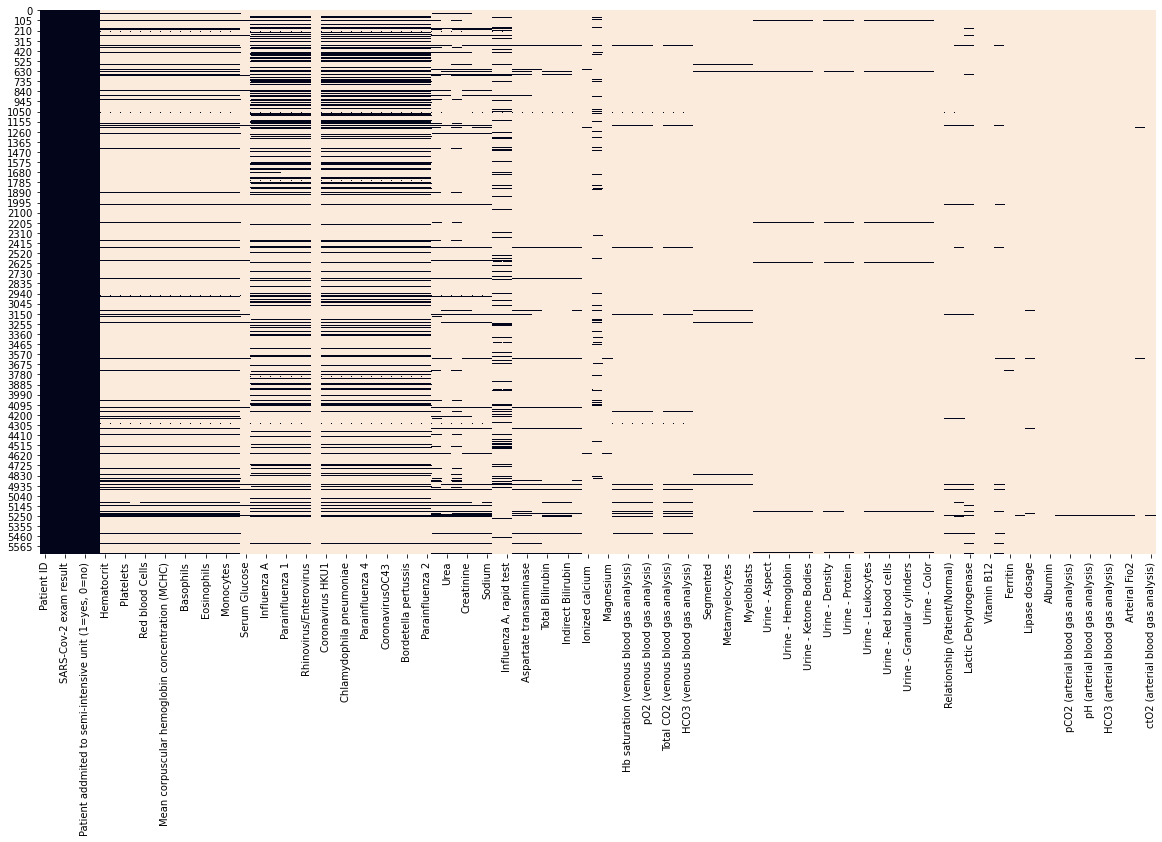

In [4]:

# Identify the columns with missing values

df.isnull().sum().sort_values() #there are no missing values

# Visualize NaN on a heatmap
df_clean = df.copy()

plt.figure(figsize=(20,10))
sns.heatmap(df_clean.isnull(), cbar = False)



nan_rate = pd.DataFrame(df_clean.isnull().sum().sort_values()) #there are no missing values
nan_rate = nan_rate.rename(columns = {0 : 'rate'})
nan_rate.reset_index(level=0, inplace=True)

df_clean_object = df_clean.select_dtypes('object')
df_clean_float = df_clean.select_dtypes('float64')
df_clean_int = df_clean.select_dtypes('int64')

nan_rate['rate'] = nan_rate['rate'] / 5644

all_missing = nan_rate[nan_rate['rate'] ==1]
high_missing = nan_rate[nan_rate['rate'] >= 0.9]

In [5]:
df_clean = df[df.columns[df.isna().sum() /df.shape[0] < 0.9]]


In [8]:
#Drop patient ID

df_clean.drop('Patient ID', axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:

#df_clean.drop(columns = all_missing['index'])
#df_clean.drop(columns = high_missing['index'])


# First level of analysis

It consists of doing the following : 

- Univariate analysis: 
    *) Variables (distribution, any grouping, any particular insight..) 
        *) maybe some focus on some particular variables like age..
    *) target variable : 
        *) Distrubtion

- Bivariate analysis
    *) Target with other variables
        *) Maybe focus on some specific variables
        
 

In [1]:
# Ratio des cas positifs covid

len(df_clean[df_clean['SARS-Cov-2 exam result']==1]) / len(df_clean['SARS-Cov-2 exam result'])
df_clean['SARS-Cov-2 exam result'].value_counts(normalize = True) # pour afficher les pourcentages

NameError: name 'df' is not defined

Almost 10% of positive cases, which makes data set sensitively imbalanced. 
Wa should use some metrics like score F1, sensibilité or precision (see last video of machine learnia 26)

## Visualizing Data 

### Univariate analysis

#### Visualizing float variables

In [36]:
# Histograms
#df_clean.hist(bins=30, figsize=(100, 60))


In [ ]:
#other methods

for col in df_clean.select_dtypes('float') :
    plt.figure()
    sns.distplot(df[col])

**All graphs are centered around 0, and seems to have a std of 1 ==> data might ave been standardized**



In [38]:
# Let's focus on age variable

# Age seems to be divided in quantile, with maximum quantile is 19. How much year is each quantile ? 
# we seem to have more samples from first age, middle age and seniors
df_clean['Patient age quantile'].max()
sns.distplot(df_clean['Patient age quantile'], bins=20)

19

We might think that each quantile represents a portion of 5 years (with the assumption that an average person live around 100 years)

#### Visualizing categorical variables

In [ ]:
for col in df_clean.select_dtypes('object') :
    print(f'{col :-<50} {df[col].unique()}')

In [ ]:
for col in df_clean.select_dtypes('object') :
    plt.figure()
    df[col].value_counts().plot.pie()

All tests seem to be majorly "not detected", except : Rhinovirus/Enterovirus

### Bivariate analysis

In [7]:
# Create two subsets of patients

positive_df = df_clean[df_clean['SARS-Cov-2 exam result']==1]
negative_df = df_clean[df_clean['SARS-Cov-2 exam result']==0]

positive_df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"


In [8]:
# Create two subsets of tests : blood and viral

missing_rate = df_clean.isnull().sum()/df_clean.shape[0]

blood = df[df_clean.columns[(missing_rate < 0.9) & (missing_rate > 0.88) ]]
viral = df[df_clean.columns[(missing_rate < 0.80) & (missing_rate > 0.75) ]]

In [ ]:
# Visialize target / blood 

for col in blood.columns : 
    plt.figure()
    sns.distplot(positive_df[col], label = 'positive' )
    sns.distplot(negative_df[col], label = 'negative' )
    plt.legend()

In [ ]:

# Target / age 

plt.figure()
sns.distplot(positive_df['Patient age quantile'], label = 'positive')
sns.distplot(negative_df['Patient age quantile'], label = 'negative')
plt.legend()

It seems that there are some differences in platelets, leukocytes and monocytes rate between positive and negative population. A hypothesis to be tested.
Those three tests seem to be linked to Covid.

In [ ]:

sns.set_style('darkgrid')
plt.figure()
sns.countplot(x='Patient age quantile', hue = 'SARS-Cov-2 exam result',  data = df_clean ) #hue is the grouping variable, that will produce different colours


In [ ]:
#Crosstab

for col in viral : 
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot = True, fmt = 'd' )
    

In [48]:
#Pair plot

In [ ]:
# Correlation matrix

plt.figure(figsize=(20,10))
sns.heatmap(df_clean_float.corr(), cbar = False)

#sns.heatmap(df_clean_float, annot=True, cmap = 'Reds', cbar = False)


In [50]:
plt.show()

# Second level of analysis 

Consists  of the following : 
    - finding relationship between variables

In [ ]:
# Relationship between blood variables 

sns.pairplot(df[blood.columns])

In [ ]:
#heatmap of correlation

sns.heatmap(df[blood.columns].corr())

In [ ]:
#heatmap of correlation

sns.clustermap(df[blood.columns].corr())

### Age with blood 

In [ ]:
for col in blood.columns : 
    plt.figure()
    sns.lmplot(x='Patient age quantile', y=col, hue = 'SARS-Cov-2 exam result', data = df_clean )

No linear relationships is clear between age and blood components.

In [ ]:
df_clean.corr()['Patient age quantile'].sort_values()

Weak correlation between age and blood components rate.

In [ ]:
viral.columns

In [ ]:
# Why do we have influenza test and 'rapid' influenza test ? let's check how they relate to each others 

pd.crosstab(df_clean['Influenza A'], df_clean['Influenza A, rapid test'])

# Pre-processing

## Objectives 

### 1. Put data in a format "ML-friendly"

- **Train / Test**
- **Encoding**
- **Cleaning NaN / outliers/Feature imputation** 

    *) Imputation: remplacer certaines valeurs manquantes par certaines valeurs statistiques 
    module : sklearn.impute

==> Create a first model and assess it

### 2. Optimize the performance of the ML model



- **Feature selection**
    
    *) Selection : select most relevant variables for the model( use khi-2 statistics to determine important variables )
    
    module : sklearn.feature_selection
    
- **Encodage / Normlisation**

    *) Mettre les valeurs entre 0 et 1 ( ce qui facilite l'apprentissage de la machine) 
    
    module : sklearn.preprocessing
    
- **Feature engineering / extraction**

    *) Générer de nouvelles variables à partir d'informations cachées dans le Data set
    ==> par exemple créer de nouvelles variables polynomiales
    
    
    module : sklearn.feature_selection
    
- **Feature scaling**
- **Cleaning outliers**

- **Discrétisation** : découper une variable continue en plusieurs parties (créer diffrentes catégories 

==> Binarizer()

==> KbinsDiscretizer()


### 1. Put data in a format "ML-friendly"

- **Train / Test and encoding**

In [9]:
# Construct a new copy of the dataframe

key_columns =['SARS-Cov-2 exam result', 'Patient age quantile']
df_ = df[list(viral.columns) + list(blood.columns) + key_columns]
cdf = df_.copy()

df_object = df_.select_dtypes('object')
df_object.drop(columns = 'SARS-Cov-2 exam result', inplace = True)
df_float = df_.select_dtypes('float64')
df_int = df_.select_dtypes('int64')

#pd.DataFrame(df_clean.isnull().sum()/df_clean.shape[0])

#df_clean_om = pd.DataFrame(df_clean.isnull().sum().sort_values()) #there are no missing values
#df_clean_om = df_clean_om.rename(columns = {0 : 'volume'})
#df_clean_om.reset_index(level=0, inplace=True)

#df_clean_om['index']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
def values_to_replace (cdf) :

    for col in df_object.columns : 
        print(cdf[col].mode()[0])
    
    for col in df_float.columns :
        print(cdf[col].mean())
    
    for col in df_int.columns :
        print(cdf[col].median())
    
    return

In [53]:
# Create a copy of df

# 1) créer un sous ensemble de variables par type

# 2) remplacer les valeurs numériques par la moyenne, les valeurs catégoriques de telle sorte à garder le même pourcentage 

# replace nan with mean for float variable

def imputation (cdf, method) :

    if method == 'fill' :
        for col in df_float.columns :
            #mean = cdf[col].mean()
            mode = cdf[col].mode()[0]
            cdf[col].replace(to_replace = np.nan, value = mode, inplace = True)
            #cdf[col].fillna(mean, inplace = True)
        # replace nan with mode for int variable
        
        for col in df_object.columns : 
            #mode = cdf[col].mode()[0]
            #cdf[col].replace(to_replace = np.nan, value = mode, inplace = True)
            cdf[col].fillna('others', inplace = True)
    # replace nan and keep balance of data for categorical variables

        for col in df_int.columns :
            median = cdf[col].median()
            cdf[col].fillna(median, inplace = True)
        #cdf[col].replace(to_replace = np.nan, value = median, inplace = True)
    
    if method == 'drop' :
        cdf.dropna(axis = 0, inplace = True)
        

# 3) utiliser un random forest pour la classification puis un xgboost
#missing_categorical = [col for col in df_.columns if df_[col].isnull.mean() > 0 and df_[col].dtypes == 'object'] 
#df_clean.isnull().sum()/df_clean.shape[0]
# if we had to replace some unformatted values with missing values
#df[col] = df[col].replace(to_replace = np.nan, value = np.nan, inplace = True)

# df with only columns having missing value'

    return cdf 

## Encoding

In [54]:
# loop that replaces each categorical value with the corresponding value in dictionary

def encoding(cdf) :

    code = { 

    'positive': 1,
    'negative' : 0,
    'detected' :1,
    'not_detected' : 0,
    'others' : -999
    }
    
    
    for col in df_.select_dtypes('object') : 
        cdf[col] = cdf[col].map(code)
    
    #le = LabelEncoder()
    #df_clean['SARS-Cov-2 exam result'] = le.fit_transform(df_clean['SARS-Cov-2 exam result'])
    # le.inverse_transform(df_['SARS-Cov-2 exam result'])
    return cdf


In [55]:
def preprocessing (df, method):
    
    df = imputation(df,method)
    df = encoding(df)
    x = df.drop('SARS-Cov-2 exam result',axis = 1)
    y = df['SARS-Cov-2 exam result']
    
    #print(y.value_counts())

    
    return x,y

In [56]:
# Le one hot encoding se fait moyennant : LabelBinarizer(sparse_output = True), OneHotEncoder()


In [57]:
# Normalization 
# *) minmax_scaler ()
# *) standardscaler()
# les deux sensibles aux valeurs aberrantes

# ==> RobustScaler () : on soustrait la médiane (et non la moyenne) et on divise par l'interquantile (écart entre 1 er et 3 ème quartiles)

In [58]:
#col in cdf.columns if col.dtypes == 'float'
#cdf.select_dtypes('int')

## Machine learning

### Random forest

In [59]:
def evaluation (model) :
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    #f1 = f1_score(y_valid, y_pred )
    print(classification_report(y_valid,y_pred))
    return  

The score when dropping na seems to be higher than when replacing with mode, mean and median

### Gradient boosting

In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')



## Create the final pipeline

In [60]:

# Copy data

cdf = df_.copy()


# Run preprocessing with a fill method
x,y = preprocessing(cdf,'fill')

# Generate train and test sets 
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)

#Construct different grids of many models to test

## SVM
param_grid_svc = {'svc__gamma' : [1e-3, 1e-4, 1e-5, 0.0005, 1e-6], 'svc__C' : [0.1, 1, 10, 100, 1000]} 

svm = GridSearchCV(make_pipeline(StandardScaler(),SVC(random_state = 0)), param_grid = param_grid_svc, n_jobs = -1, cv = 5,  scoring = 'recall')

## Random forest

param_grid_rfc = {'n_estimators' : [80, 90, 100], 'max_depth' : [2, 4]} 
rfc = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = param_grid_rfc , cv=5)
#rfc = RandomForestClassifier(random_state = 0)


## Gradient boosting

#gbc = GridSearchCV(GradientBoostingClassifier(random_state = 0), param_grid = , cv=5)
gbc = GradientBoostingClassifier(random_state = 0)


## K nearest Neighbors
knn = make_pipeline(StandardScaler(),KNeighborsClassifier())
    
pipelines = [svm, rfc, gbc, knn]

pipe_dict = {0 : 'svm', 1 : 'Random forest', 2 :'Gradient boosting', 3: 'knn'}                     
                    
#Evaluate the model 
for i, pipe in enumerate(pipelines) :
#    print("{} accuracy is {}".format(pipe_dict[i], evaluation(pipe) ))

    print('model is : {}'.format(pipe_dict[i]))
    evaluation(pipe)

model is : svm
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1018
           1       0.60      0.05      0.10       111

    accuracy                           0.90      1129
   macro avg       0.75      0.53      0.52      1129
weighted avg       0.88      0.90      0.87      1129

model is : Random forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1018
           1       0.00      0.00      0.00       111

    accuracy                           0.90      1129
   macro avg       0.45      0.50      0.47      1129
weighted avg       0.81      0.90      0.86      1129

model is : Gradient boosting
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1018
           1       0.55      0.05      0.10       111

    accuracy                           0.90      1129
   macro avg       0.73      0.52      0.52      1129
weighted avg       0.87      0.90      0.86      1129

model is : knn
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1018
           1       0.23      0.06      0.10       111

    accuracy                           0.89      1129
   macro avg       0.57      0.52      0.52      1129
weighted avg       0.84      0

In [27]:
def pipeline_final(selection, method, chi_f):
    

    # Copy data

    cdf = df_.copy()

    # Run preprocessing with a fill method
    x,y = preprocessing(cdf,method)

    # Generate train and test sets 
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)
    
    if selection == 'variance' :
            
        selector = VarianceThreshold(threshold = 0.02)
        selector.fit_transform(x_train)
        var_support = selector.get_support()
        var_feature = x_train.loc[:,var_support].columns.tolist()
        x_train = x_train[var_feature]

    if selection == 'chi' :
            
        x_train_chi = x_train[df_object.columns.tolist() + df_int.columns.tolist()]
        selector = SelectKBest(chi2, k = chi_f)
        selector.fit(x_train_chi,y_train) 
        chi_support = selector.get_support()
        chi_feature = x_train_chi.loc[:,chi_support].columns.tolist()
        x_train = x_train[x_train[chi_feature].columns.tolist() + df_int.columns.tolist() + df_float.columns.tolist()]
    
    if selection == 'learn': 
        
        selector = SelectFromModel (SGDClassifier (random_state = 0), threshold = 'mean')
        selector.fit(x_train,y_train)
        sgd_support =  selector.get_support()

        sgd_feature = x_train.loc[:,sgd_support].columns.tolist()
        com_col = x_train.drop(columns = sgd_feature)
        x_train = x_train[x_train[sgd_feature].columns.tolist() + com_col.columns.tolist()]
        #Construct different grids of many models to test

    ## SVM
    param_grid_svc = {'svc__gamma' : [1e-3, 1e-4, 1e-5, 0.0005, 1e-6], 'svc__C' : [0.1, 1, 10, 100, 1000]} 
    #param_grid_svc = { 'svc__C' : [0.1, 1, 10, 100, 1000]} 
    
    svm = GridSearchCV(make_pipeline(StandardScaler(),SVC(random_state = 0)), param_grid = param_grid_svc, n_jobs = -1, cv = 2 )

    ## Random forest

    param_grid_rfc = {'n_estimators' : [80, 90, 100, 110,120], 'max_depth' : [2, 4, 5]} 
    rfc = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = param_grid_rfc , cv=5)
    #rfc = RandomForestClassifier(random_state = 0)


    ## Gradient boosting

    #gbc = GridSearchCV(GradientBoostingClassifier(random_state = 0), param_grid = , cv=5)
    gbc = GradientBoostingClassifier(random_state = 0)


    ## K nearest Neighbors
    knn = KNeighborsClassifier()
    
    pipelines = [svm, rfc, gbc, knn]

    pipe_dict = {0 : 'svm', 1 : 'Random forest', 2 :'Gradient boosting', 3: 'knn'}                    
                    
    #Evaluate the model 
    for i, pipe in enumerate(pipelines) :
        print("{} f1 score is {}".format(pipe_dict[i], evaluation(pipe) ))

In [19]:
# Next steps : 

# 0) add more hyperparameter tuning to models 

# 2) use PCA
# 3) use a different method to fill NaNs
# 4) Other feature engineering 

In [29]:
i = 1
for a in  ['fill','drop'] :
    for b in ['variance', 'chi', 'learn']:
        if b =='chi' :
            
            for c in range(10,15) :
                print('Combination number {}'.format(i))
                print('Nan method :{}  feature selection method : {}'.format(a,b))
                pipeline_final(b,a, c)
                i+=1
        else : 
                print('Nan method :{}  feature selection method : {}'.format(a,b))
                pipeline_final(b,a,1)
                i+=1
            
    #def pipeline_final(selection, method, chi_f):

Nan method :fill  feature selection method : variance
svm f1 score is 0.09836065573770493
Random forest f1 score is 0.0
Gradient boosting f1 score is 0.1
knn f1 score is 0.049689440993788817
Combination number 2
Nan method :fill  feature selection method : chi
svm f1 score is 0.09836065573770493
Random forest f1 score is 0.0
Gradient boosting f1 score is 0.1
knn f1 score is 0.049689440993788817
Combination number 3
Nan method :fill  feature selection method : chi
svm f1 score is 0.09836065573770493
Random forest f1 score is 0.0
Gradient boosting f1 score is 0.1
knn f1 score is 0.049689440993788817
Combination number 4
Nan method :fill  feature selection method : chi
svm f1 score is 0.09836065573770493
Random forest f1 score is 0.0
Gradient boosting f1 score is 0.1
knn f1 score is 0.049689440993788817
Combination number 5
Nan method :fill  feature selection method : chi
svm f1 score is 0.09836065573770493
Random forest f1 score is 0.0
Gradient boosting f1 score is 0.1
knn f1 score is 0.

KeyboardInterrupt: 

In [27]:
svm.best_params_

{'svc__C': 1000, 'svc__gamma': 0.0001}

In [ ]:
model = make_pipeline(preprocessing, RandomForestClassifier())

model.fit(x_train, y_train)
model.predict(x_test)

# Feature selection

In [72]:
# 1) Feature selection : retain only important features 

# 1.1) Retain only variable with variances > threshold

# a) Calculate variances of all variables
# x.var(axis = 0)
# b) Use function to filter small variances
# selector = VarianceThreshold(threshold = 0.2)
# selector.fit_transform(x)
# selector.get_support() (génère une liste avec true/false des colonnes qui dépassent le seuil)

# 2.2) Selectionner les variables en fonction des tests de dépendance (qui ont le plus de dépendance avec la target, comme khi 2, anova)
# (Filter based)

# a) SelectKBest
# from sklearn.feature_selection import SelectKBest, chi2
#chi2(x,y) (génère la score tu teste avec chacune des features)
# selector = SelectKbest(chi2, k = 1)
# selector.fit(x,y) (on fait passer aussi y, car le test chi2 en a besoin)
# selector.get_support() (génère une liste avec true/false des k feature qu'on retient)

# 2.3) Entrainer un modèle paramétrique / paramétré, et ne garder que les feature pour lesquelles les paramétres appris sont importants
# (ex de modèle non paramétré Knearestneighbours)


# 2.3.1) Eliminer toutes les variables en une seule itération (# Wrapper-based )

# from sklearn.feature_selection import SelectFromModel
# selector = SelectFromModel (SGDClassifier (random_state = 0), threshold = 'mean')
# selector.fit_transform(x_train,y)
# selector.get_support()
# selector.estimator_.coef_.mean(axis =0).mean()


# 2.3.2) Eliminer les variables de manière récursive (Embedded)
# from sklearn.feature_selection import RFE, RFECV
# selector = RFECV(SGDClassifier(random_state = 0), stpe = 1, min_features_to_select = 2, cv = 5)
# selector.fit(x_train,y)
# selector.ranking_ (list with final ranking of each feature)
# selector.grid_scores_ (gives the score at each step)

Pourquoi ces selectors doivent être appliqués uniquement à x_train et non à x_valid / x_test ?

In [ ]:
# 1.1) Retain only variable with variances > threshold

# from sklearn.feature_selection import SelectKBest, chi2
#chi2(x,y) (génère la score tu teste avec chacune des features)
# selector = SelectKbest(chi2, k = 1)
# selector.fit(x,y) (on fait passer aussi y, car le test chi2 en a besoin)
# selector.get_support() (génère une liste avec true/false des k feature qu'on retient)

# c) use these columns to train the machine learning

x_train_var = x_train[var_feature]

In [92]:

cdf = df_.copy()
# Run preprocessing with a fill method
x,y = preprocessing(cdf,'fill')

# Generate train and test sets 
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)


selector = SelectFromModel (SGDClassifier (random_state = 0), threshold = 'mean')
selector.fit(x_train,y_train)
sgd_support =  selector.get_support()

sgd_feature = x_train.loc[:,sgd_support].columns.tolist()
com_col = x_train.drop(columns = sgd_feature)
x_train = x_train[x_train[sgd_feature].columns.tolist() + com_col.columns.tolist()]

x_train
        

0    5086
1     558
Name: SARS-Cov-2 exam result, dtype: int64


,Respiratory Syncytial Virus,Influenza A,Influenza B,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus,Leukocytes,Parainfluenza 1,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,Bordetella pertussis,Parainfluenza 2,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Patient age quantile
543,0,0,0,0,0,0,0,0,0,0,2.755010e-01,0,0,0,0,0,0,0,1.358055e+00,1.356092e+00,-2.284914e-01,-4.380969e-01,1.142196e+00,-5.174807e-01,2.441486e-01,-2.237665e-01,1.781750e-01,-7.933683e-01,6.604462e-02,9.878638e-01,-5.877498e-03,18
4937,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,11
2884,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,3
1837,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,15
2228,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,0
3264,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,6
1653,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,14
2607,0,0,0,0,0,0,0,0,0,0,6.215833e-09,0,0,0,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,11
